In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from matplotlib.colors import to_hex
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import geodatasets
import rasterio
from rasterio.transform import from_origin
import matplotlib.colors as mcolors
from shapely.geometry import box
from scipy.spatial import cKDTree

from scripts.geodata import *

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2


In [2]:
month_abbr_hydr = {
    'sep': 1,
    'oct': 2,
    'nov': 3,
    'dec': 4,
    'jan': 5,
    'feb': 6,
    'mar': 7,
    'apr': 8,
    'may': 9,
    'jun': 10,
    'jul': 11,
    'aug': 12,
}

## Satellite data to nc:

In [3]:
# Sentinel-2
path_S2 = '../../../data/Sentinel/'
path_S2_2021 = path_S2 + '2021/'
src_crs = 'EPSG:4326'  # Original CRS (lat/lon) wgs84

os.listdir(path_S2_2021)

['GLF_S2B_MSIL1C_20210610T101559_N0300_R065_T32TMS_20210610T122936_10m_r.tif',
 'GLF_S2A_MSIL1C_20210913T102021_N0301_R065_T32TMS_20210913T123114_10m_r.tif',
 'GLF_S2B_MSIL1C_20210720T101559_N0301_R065_T32TMS_20210720T122800_10m_r.tif',
 'GLF_S2A_MSIL1C_20210923T102031_N0301_R065_T32TMS_20210923T122939_10m_r.tif',
 'GLF_S2B_MSIL1C_20210710T101559_N0301_R065_T32TMS_20210710T122740_10m_r.tif',
 'GLF_S2B_MSIL1C_20210531T101559_N0300_R065_T32TMS_20210531T130120_10m_r.tif',
 'GLF_S2B_MSIL1C_20210918T101639_N0301_R065_T32TMS_20210918T125356_10m_r.tif',
 'GLF_S2A_MSIL1C_20210615T102021_N0300_R065_T32TMS_20210615T122505_10m_r.tif',
 'GLF_S2A_MSIL1C_20210814T102031_N0301_R065_T32TMS_20210814T122650_10m_r.tif',
 'GLF_S2A_MSIL1C_20210824T102031_N0301_R065_T32TMS_20210824T122603_10m_r.tif']

In [4]:
input_raster = path_S2_2021 + 'GLF_S2A_MSIL1C_20210913T102021_N0301_R065_T32TMS_20210913T123114_10m_r.tif'

# Open the raster
with rasterio.open(input_raster) as src:
    data = src.read(1)  # Read first band
    transform = src.transform
    crs = src.crs

# Get indices of non-NaN values
rows, cols = np.where(data != src.nodata)
values = data[rows, cols]

# Convert raster cells to points
points = [
    Point(transform * (col + 0.5, row + 0.5)) for row, col in zip(rows, cols)
]

# Create GeoDataFrame
gdf_raster = gpd.GeoDataFrame({"data": values}, geometry=points, crs=crs)

In [11]:
# get glacier coordinates:
glacierName = 'aletsch'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

# open xarray:
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_latlon_g = GaussianFilter(ds_latlon)

# Convert to GeoPandas
gdf_glacier, lon, lat = toGeoPandas(ds_latlon_g)

# Make classification map of snow/ice:
# Replace values: below 0 with 3, above 0 with 1
gdf_class = gdf_glacier.copy()
tol = 0
gdf_class.loc[gdf_glacier['data'] <= 0 + tol, 'data'] = 3
gdf_class.loc[gdf_glacier['data'] > 0 + tol, 'data'] = 1

gdf_clipped_res = resampleRaster(gdf_glacier, gdf_raster)

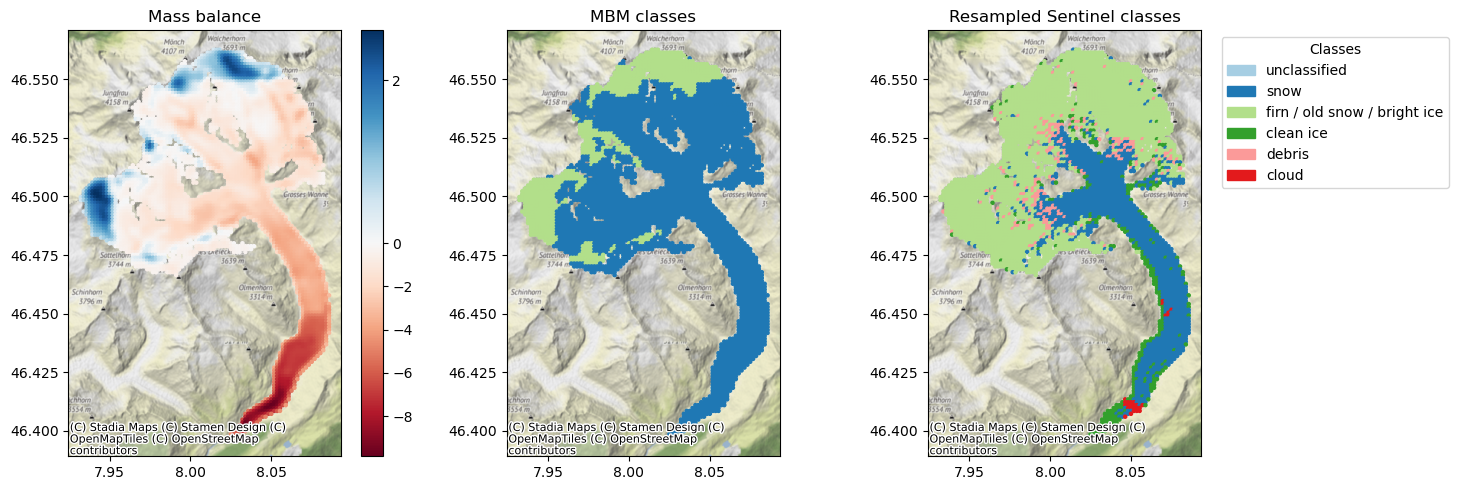

In [38]:
import matplotlib.patches as mpatches

# Define the colors for categories (ensure that your categories match the color list)
colors_cat = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
    '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

# Manually map categories to colors (assuming categories 0-5 for example)
map = dict(zip(gdf_clipped_res.data.unique(),
               colors_cat[:6]))  # Adjust according to the number of categories

# Set up the basemap provider
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first figure (Mass balance)
vmin, vmax = gdf_glacier.data.min(), gdf_glacier.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
gdf_clean = gdf_glacier.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN datas
)
cx.add_basemap(axs[0], crs=gdf_glacier.crs, source=provider)
axs[0].set_title("Mass balance")

# Plot the second figure (MBM classes)
gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean['color'] = gdf_clean['data'].map(map)
# Plot with manually defined colormap
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"},  # Define color for NaN datas
    categorical=True,  # Ensure the plot uses categorical colors
    ax=axs[1],
    color=gdf_clean['color']  # Use the custom colormap
)
cx.add_basemap(axs[1], crs=gdf_glacier.crs, source=provider)
axs[1].set_title("MBM classes")

# Plot the third figure (Resampled Sentinel classes)
gdf_clean = gdf_clipped_res.dropna(subset=["data"])
gdf_clean['color'] = gdf_clean['data'].map(map)
# Plot with manually defined colormap
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"},  # Define color for NaN datas
    categorical=True,  # Ensure the plot uses categorical colors
    ax=axs[2],
    color=gdf_clean['color']  # Use the custom colormap
)
cx.add_basemap(axs[2], crs=gdf_glacier.crs, source=provider)
axs[2].set_title("Resampled Sentinel classes")

# Manually add custom legend for the third plot
classes = ['unclassified', 'snow', 'firn / old snow / bright ice', 'clean ice', 'debris', 'cloud', 'no data']
handles = [mpatches.Patch(color=color, label=classes[i]) for i, color in enumerate(colors_cat[:len(map)])]
axs[2].legend(handles=handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot with consistent colors
plt.tight_layout()
plt.show()

## Transform to tif rasters for QGIS:

### One year:

In [ ]:
glacierName = 'aletsch'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

filename_tif = f"{glacierName}_{year}.tif"
path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
path_tif_lv95 = f"results/tif/{glacierName}/lv95/"

createPath(path_tif_lv95)
createPath(path_tif_wgs84)

In [ ]:
gdf, gdf_class, raster_data, extent = TransformToRaster(
    filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84, path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)
plt.tight_layout()

In [ ]:
vmin, vmax = gdf.data.min(), gdf.data.max()

# Calculate the relative position of 0
relative_position = (0 - vmin) / (vmax - vmin) * 100

# Print the result
print(f"The relative position of 0 is {relative_position:.2f}%")

### All years:

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    print(year)
    for month in month_abbr_hydr:
        monthNb = month_abbr_hydr[month]

        filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
        path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
        path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

        filename_tif = f"{glacierName}_{year}_{monthNb}.tif"
        path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
        path_tif_lv95 = f"results/tif/{glacierName}/lv95/"  # normally EPSG Code: 2056

        gdf, gdf_class, raster_data, extent = TransformToRaster(
            filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84,
            path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

## Step by step example of one file:

### Step 1: Open the NetCDF file


In [ ]:
ds_xy = xr.open_dataset(path_nc_lv95 + filename_nc)
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)

# Show effet of Smoothing:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_xy.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])
axs[0].set_title('Original')

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])
axs[1].set_title('Gaussian Filter')

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values, ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [ ]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
# gdf_lv95 = gdf.to_crs("EPSG:2056")

API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [ ]:
# Transform to raster from geopandas
raster_data, extent = toRaster(gdf,
                               lon,
                               lat,
                               file_name=path_tif_wgs84 + filename_tif)

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(path_tif_wgs84 + filename_tif,
                         path_tif_lv95 + filename_tif)

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName:
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
                  'results/tif/claridenU_2022_w_lv95.tif',
                  'results/tif/clariden_2022_w_lv95.tif')